In [2]:
#import necessary packages

import pathlib as Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models
#from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence 
import torch.nn.functional as F
import os
import pydicom as dicom
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import matplotlib.image as img
import zipfile
import cv2
#from google.colab.patches import cv2_imshow
from tqdm import tqdm
import time
from PIL import Image
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [24]:
scan_dir = 'data/images'
mask_dir = 'mask'

scan_list = os.listdir(scan_dir)
mask_list = os.listdir(mask_dir)
scan_list = scan_list

img_list = []

for each in scan_list:
    if not each.startswith('.'):
        img_list.append(each)
img_list = sorted(img_list)

num_patient = len(img_list)

print(img_list)
print(num_patient)

['images_01', 'images_02', 'images_03', 'images_04', 'images_05', 'images_06', 'images_07', 'images_08', 'images_09', 'images_10', 'images_11', 'images_12', 'images_13', 'images_14', 'images_15', 'images_16', 'images_17', 'images_18', 'images_19', 'images_20', 'images_21', 'images_22', 'images_23']
23


In [4]:
classes = {
    0 : 'background',
    1 : 'pelvic bone',
    2 : 'femur',
    3 : 'low spine bone',
    4 : 'mid spine bone',
    5 : 'high spine bone'
}

In [5]:
# functtion that shows 6 tissues ground truth image
def mask2img(mask):
    palette = {
        0: (0, 0, 0),
        1: (255, 0, 0),
        2: (0, 255, 0),
        3: (0, 0, 255),
        4: (0, 255, 255),
        5: (255, 255, 0)
    }
    palette_norm = {
        0: (0, 0, 0),
        1: (1, 0, 0),
        2: (0, 1, 0),
        3: (0, 0, 1),
        4: (0, 1, 1),
        5: (1, 1, 0)
    }
    rows = mask.shape[0]
    cols = mask.shape[1]
    image = np.zeros((rows, cols, 3), dtype=np.uint8)
    for j in range(rows):
        for i in range(cols):
            image[j, i] = palette[int(mask[j, i])]

    patch0 = mpatches.Patch(color=palette_norm[0], label=classes[0])
    patch1 = mpatches.Patch(color=palette_norm[1], label=classes[1])
    patch2 = mpatches.Patch(color=palette_norm[2], label=classes[2])
    patch3 = mpatches.Patch(color=palette_norm[3], label=classes[3])
    patch4 = mpatches.Patch(color=palette_norm[4], label=classes[4])

    handles = [patch0, patch1, patch2, patch3, patch4]
    return image, handles

In [6]:
def show_pair(scan_num=5, slice_num=27):
    image = 'images_' + str(scan_num)
    mask = 'images_' + str(scan_num) + '_mask.nii'

    image_dir = os.path.join(scan_dir, image)
    mask = os.path.join(mask_dir, mask)
    scan = os.path.join(image_dir, sorted(os.listdir(image_dir))[slice_num-1])

    test_img = dicom.read_file(scan)
    test_img = test_img.pixel_array

    mask_img = nib.load(mask).get_fdata()
    mask_img = np.rot90(mask_img, 1)
    mask_img = cv2.flip(mask_img, 0)
    
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(test_img, cmap=plt.cm.bone)  # set the color map to bone
    mask_image, handles = mask2img(mask_img[:,:,slice_num-1])
    ax[0].set_title('2D Slice')
    print(mask_image.shape)
    ax[1].imshow(mask_image)
    ax[1].legend(handles=handles, bbox_to_anchor=(1.85, 1))
    ax[1].set_title('Ground Truth Segmentation Mask')
    fig.savefig('figs/test_scan_mask_pair.jpg')
    fig.suptitle('Side-by-Side Comparsion Between 2D Slice and Mask')
    print(np.unique(mask_img[:,:,slice_num-1]))

(384, 384, 3)
[0. 1. 2. 3. 4. 5.]


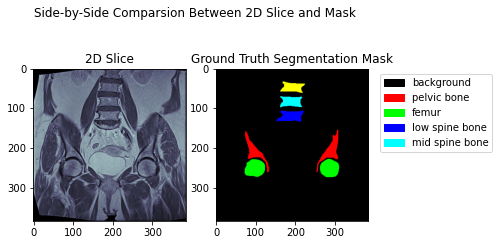

In [7]:
show_pair()

In [8]:
def create_gif():
    dir = 'data/images/images_1'
    length = len(os.listdir(dir))
    dir_list = os.listdir(dir)

    for i in range(length):
        scan_dir = dir_list[i]
        scan = os.path.join(dir, os.listdir(dir)[i])
        print(scan)
        test_img = dicom.read_file(scan)
        test_img = test_img.pixel_array

        fig,ax = plt.subplots()
        ax.imshow(test_img, cmap=plt.cm.bone)
        name = 'gif'+str(i)
        fig.savefig('figs/'+name)

## Function to stack the input 2d slices and save it into another directory

In [26]:
class config:
    ORIG_HEIGHT = 384
    ORIG_WIDTH = 384

In [38]:
def stack_slices(patient_index, scan_dir=scan_dir, slice_list=img_list):
    new_dir = 'data/images_3d/'
    new_file = 'images_'
    if patient_index < 10:
        name = '0' + str(patient_index)
    else:
        name = str(patient_index)
    new_file_path = new_dir + new_file + name + '.npy'

    patient_index = img_list[patient_index-1]
    patient_dir = os.path.join(scan_dir, patient_index)
    slice_len = len(os.listdir(patient_dir))
    slice_list = sorted(os.listdir(patient_dir))
    empty_3d_list = np.zeros((config.ORIG_HEIGHT, config.ORIG_WIDTH, slice_len))
    for i in range(slice_len):
        slice = os.path.join(patient_dir, slice_list[i])
        read = dicom.read_file(slice).pixel_array
        empty_3d_list[:, :, i] = read
    #plt.imshow(empty_3d_list[:,:,15])
    np.save(new_file_path, empty_3d_list)
    return empty_3d_list

# This will create new directory with stacked 2D scans for each patient
# for i in range(1, num_patient+1):
#     stack_slices(patient_index=i)

(384, 384, 47)


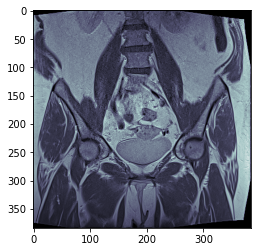

In [59]:
dir = 'mask/images_1_mask.nii'
dir2 = 'data/images_3d/images_01.npy'
print(nib.load(dir).get_fdata().shape)
plt.imshow(np.load(dir2)[:,:,25], cmap=plt.cm.bone)